This is a multilabel classification task that output the degree of confidence `(probability)` a trained model has about a row of feature belonging to a particular class its trained on.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,text_lenght
count,10333.000000
mean,13.343076
std,19.077026
min,1.000000
25%,4.000000
50%,8.000000
75%,16.000000
max,467.000000


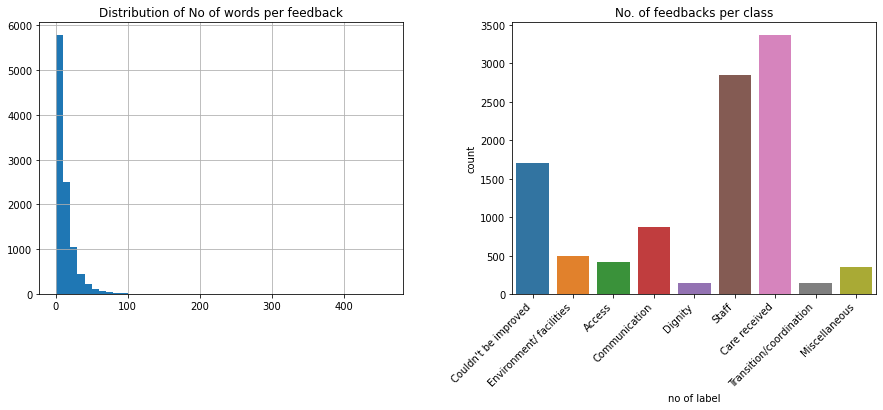

In [94]:
# ==================================================== Exploratory Data Analysis ====================================================
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.dropna(inplace=True)

# # preprocess the data and split to train, test
no = len(df)
df['text_lenght'] = [len(x.split()) for x in df.feedback] 
texts = df[['feedback', 'text_lenght']][:no]

fig, ax = plt.subplots(1,2, figsize=(15,5))
df.hist(bins = np.arange(0,max(df.text_lenght),10), ax=ax[0])
ax[0].set(title='Distribution of No of words per feedback',)
sns.countplot(df.label, ax=ax[1]).set(xlabel='no of label', title='No. of feedbacks per class',)
plt.xticks(rotation = 45, ha='right')

df.describe()

In [ ]:
#==================================================== Each row probabilities adds up to 1 ====================================================
# %%time
import pandas as pd 
import numpy as np

!python -m spacy download en_core_web_md
import en_core_web_md as model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score 

# Load data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.dropna(inplace=True)

# # preprocess the data and split to train, test
nlp = model.load()
no = len(df)
# text_lenght = [len(x.split()) for x in df.feedback][:no]
# text_lenght= np.reshape(text_lenght, (-1,1)) 
texts = np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in df.feedback])[:no]
# features = np.concatenate((texts, text_lenght), axis=1)                                 #Model does better without the additional feature (text_lenght)
features = texts
le = LabelEncoder().fit(df.label)    # create the label encoder object(needed for converting our prediction back to the text labels)
labels = le.transform(df.label)[:no]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=0, stratify=labels) # create validation set

# Instantiate a spacy nlp object with your chosen model
nlp = model.load()
# x_train.feedback = np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in x_train.feedback])
# x_test.feedback = np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in x_test.feedback])

# Instantiate a model object and train the model
cls = LogisticRegression().fit(x_train, y_train)
pred_prob = cls.predict_proba(x_test)

# Evaluation the model
pred = np.argmax(pred_prob, axis=-1)
print('='*20) 
print(f'Model Accuracy is {accuracy_score(y_test, pred)}') 
print(f'Model Bal Accuracy is {balanced_accuracy_score(y_test, pred)}') 
print('='*20)

# Apply model on full data
print('\nPredicting on full dataset')
# texts.feedback = np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in texts])
all_pred_prob = cls.predict_proba(features)

# Single labeling
all_pred = [int(v) for v in np.argmax(all_pred_prob, axis=-1)]
print(f'Overall model Accuracy is {accuracy_score(labels, all_pred)}')
print(f'Overall Model Bal Accuracy is {balanced_accuracy_score(labels, all_pred)}') 
# df['pred_label'] = le.inverse_transform(all_pred) 

# # Multi-label prediction on the full dataset
# print('\nPredicting for Multilabeling') 
# best_labels = []
# for a, i in enumerate(all_pred_prob):                                # itererate over each row 
#   threshold = 0.3
#   best_labels_dict = {k:v for k,v in enumerate(i) if v>threshold}    # extract  as a dictionary the index and values of probaility greater than the threshold percentage
#   best_labels_id = sorted(best_labels_dict, key=best_labels_dict.get, reverse=True) # Extract the label code(the best_labels_dict keys) arrange in decreasing order of their probability values
#   best_label = le.inverse_transform(best_labels_id)                  # convert the label code into the original class names             
#   best_labels.append(best_label)
#   # or 
#   df.loc[a,'multi_label'] = ', '.join(best_label)
#   # df.loc[a,'multi_label'] = best_label

# Output Probability value for each label
col = le.inverse_transform(list(set(labels)))
for i,p in enumerate(all_pred_prob):        # Ge the row index and label probabilities of each row
    df.loc[i,col] = [round(v,3) for v in p]             # Assign the rounded probability to its label (this is directly possible because the probalities is arrange in aphebetical order of the unique values of the label)

print('\nAll Done\n')
print(max(df.iloc[:, -9:].sum(axis=1)))      # To confirm that the probabilities across each row roughly add up to 1
df.head(20)

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=7d2584da75e416994f976622a8b4bf18be2ec7052a6402d7be59f44447c9d81f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mw7pbjkg/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy is 0.6816642477019835
Model Bal Accuracy is 0.4500516064499671

Predicting on full dataset
Overall model Accuracy is 0.707732507500242
Overall Model Bal Accuracy is 0.4926483519269103

All Done

1.0030000000000001


,label,feedback,Access,Care received,Communication,Couldn't be improved,Dignity,Environment/ facilities,Miscellaneous,Staff,Transition/coordination
0,Couldn't be improved,Nothing.,0.000,0.000,0.000,0.988,0.000,0.000,0.012,0.000,0.000
1,Environment/ facilities,Temperature in theatre a little low.,0.009,0.015,0.001,0.000,0.000,0.972,0.000,0.002,0.000
2,Access,Same service available at Bingham Health Centre.,0.763,0.179,0.015,0.002,0.001,0.003,0.005,0.012,0.021
3,Communication,Appointment details given over phone - no phys...,0.078,0.548,0.148,0.111,0.006,0.005,0.019,0.068,0.018
4,Communication,On one occasion I was not made aware that my a...,0.466,0.253,0.050,0.015,0.012,0.030,0.010,0.078,0.086
5,Environment/ facilities,The blood pressure monitor and cuff smelt of c...,0.016,0.145,0.078,0.060,0.033,0.517,0.017,0.102,0.032
6,Couldn't be improved,Nothing at present.,0.006,0.012,0.021,0.925,0.002,0.004,0.021,0.008,0.001
7,Access,Long wait for the appointment.,0.947,0.047,0.001,0.000,0.000,0.000,0.000,0.001,0.004
8,Dignity,2 Staff Members I had an issue with in regards...,0.051,0.218,0.132,0.055,0.031,0.017,0.023,0.411,0.063
9,Couldn't be improved,Absolutely nothing,0.000,0.000,0.000,0.960,0.000,0.000,0.040,0.000,0.000


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
... Processing Access
Test accuracy is 0.9610085019055995
all data accuracy is 0.9623572672730791
... Processing Care received
Test accuracy is 0.7936089123424216
all data accuracy is 0.8250435455777047
... Processing Communication
Test accuracy is 0.9340369393139841
all data accuracy is 0.9378749758080124
... Processing Couldn't be improved
Test accuracy is 0.9416593374377016
all data accuracy is 0.9466808592994
... Processing Dignity
Test accuracy is 0.9850483729111698
all data accuracy is 0.9866460228372363
... Processing Environment/ facilities
Test accuracy is 0.9639401934916447
all data accuracy is 0.9618734275208051
... Processing Miscellaneous
Test accuracy is 0.9742011140428027
all data accuracy is 0.973582349525837
... Processing Staff
Test accuracy is 0.8501905599530929
all data accuracy is 0.8708147861428295
... Processing Transition/coordination
Test accur

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,label,feedback,Access,Care received,Communication,Couldn't be improved,Dignity,Environment/ facilities,Miscellaneous,Staff,Transition/coordination,multi_label
0,Couldn't be improved,Nothing.,0.003082,0.002151,0.003487,0.997562,0.002452,0.003662,0.009351,0.003237,0.002676,Couldn't be improved
1,Environment/ facilities,Temperature in theatre a little low.,0.045199,0.186167,0.081941,0.116867,0.014572,0.205404,0.023925,0.141986,0.017867,NaN
2,Access,Same service available at Bingham Health Centre.,0.257112,0.258509,0.062268,0.069898,0.009619,0.053442,0.021045,0.094054,0.015990,NaN
3,Communication,Appointment details given over phone - no phys...,0.042009,0.437596,0.064798,0.089122,0.005915,0.017235,0.020779,0.055636,0.010976,Care received
4,Communication,On one occasion I was not made aware that my a...,0.153644,0.333962,0.291494,0.040760,0.013272,0.057611,0.013224,0.087167,0.041844,NaN


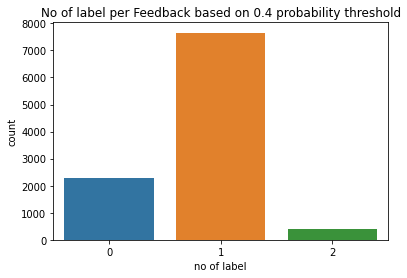

In [101]:
#==================================================== Each row probabilities don't neccesarily add up to 1 ====================================================
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_word = set(stopwords.words('english'))
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import seaborn as sns

# Load in the data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.feedback.fillna('', inplace=True)

# try do one-hot encoding of the labels 
lb = LabelBinarizer().fit(df.label)
classes = lb.transform(df.label)
class_df = pd.DataFrame(classes, columns=lb.classes_)
df = pd.concat([df, class_df], axis=1)

train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.feedback
X_test = test.feedback

# for cat in set(df.label):
  
  
# Define a pipeline combining a text feature extractor with multi lable classifier
LogReg_pipeline = Pipeline([
               ('tfidf', TfidfVectorizer(stop_words=stop_word)),
               ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
               ])

# probs = {} 
# all_pred_prob = []
for category in lb.classes_:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))   # explore the model performance on the test data
    
    # print('\nPredicting probability on full dataset')
    all_prediction = LogReg_pipeline.predict(df.feedback)
    print('all data accuracy is {}'.format(accuracy_score(df[category], all_prediction))) # explore the model performance on all the data
    probs = LogReg_pipeline.predict_proba(df.feedback)
    df[category] = [p[-1] for p in probs]                         # extract the probabilities for label 1 = represent that the row belongs to the specified class
    print('='*40)


# Multi-label prediction on the full dataset
print('\nPredicting for Multilabeling') 
all_pred_prob = df.iloc[:, -9:].values
threshold = 0.4
multilabel_counter = 0
label_counter = []
for i, p in enumerate(all_pred_prob):                                # itererate over each row 
  best_labels_dict = {k:v for k,v in enumerate(p) if v>threshold}    # extract  as a dictionary the index and values of probaility greater than the threshold percentage
  best_labels_id = sorted(best_labels_dict, key=best_labels_dict.get, reverse=True) # Extract the label code(best_labels_dict.keys) arranged in decreasing order of their probability values
  best_label = le.inverse_transform(best_labels_id)                  # convert the label code into the original class names   
  label_counter.append(len(best_label))          

  if len(best_label) < 1:
    df.loc[i,'multi_label'] = np.nan
  else:
    df.loc[i,'multi_label'] = ', '.join(best_label)

  if len(best_label) > 1:
    multilabel_counter+=1
    
print('Number of rows with MultiLabel is ', multilabel_counter) 
print('Maximum rowsum of probability is ', round(max(df.iloc[:, -9:].sum(axis=1)),2))    # To confirm that the probabilities across each row didn't auto add up to 1

sns.countplot(label_counter).set(xlabel='no of label', title=f'No of label per Feedback based on {threshold} probability threshold')
df.head()